<a href="https://colab.research.google.com/github/KristinaBorovikS/ML/blob/main/HW6/hw6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

    culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g     sex
0               39.1             18.7              181.0       3750.0    MALE
1               39.5             17.4              186.0       3800.0  FEMALE
2               40.3             18.0              195.0       3250.0  FEMALE
3                NaN              NaN                NaN          NaN     NaN
4               36.7             19.3              193.0       3450.0  FEMALE
5               39.3             20.6              190.0       3650.0    MALE
6               38.9             17.8              181.0       3625.0  FEMALE
7               39.2             19.6              195.0       4675.0    MALE
8               34.1             18.1              193.0       3475.0     NaN
9               42.0             20.2             5000.0       4250.0    MALE
10              37.8             17.1              186.0       3300.0     NaN
11              37.8             17.3              180.0       3

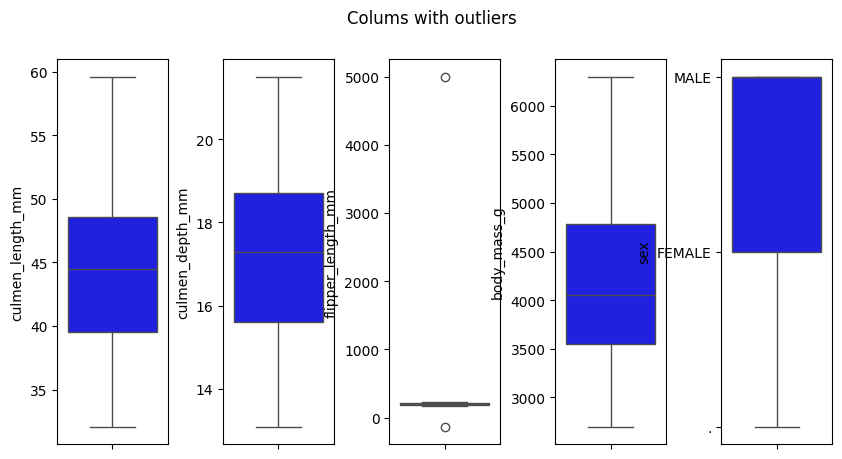

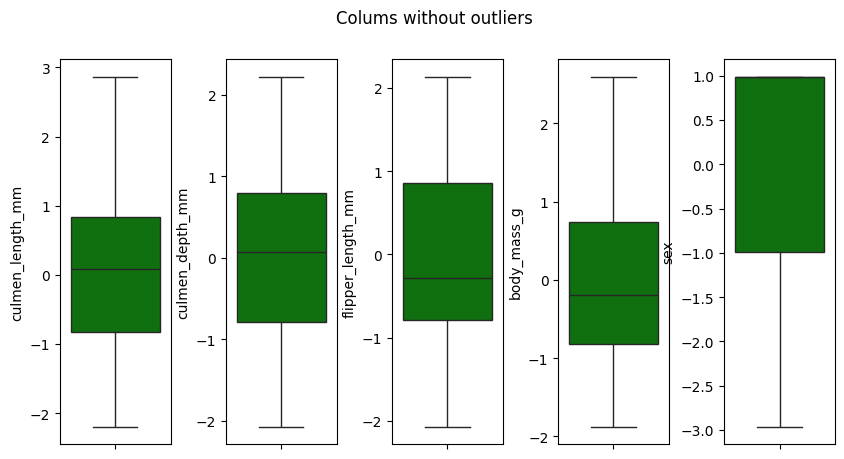

In [30]:
!pip install umap-learn
import plotly.express as px
from umap import UMAP
import pandas as pd
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.cluster import OPTICS
from sklearn.cluster import MeanShift, estimate_bandwidth, SpectralClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import silhouette_samples


warnings.filterwarnings("ignore")
penguins_df = pd.read_csv("penguins.csv")
print(penguins_df.head(15))
print(penguins_df.info())
df_new = penguins_df.replace('', pd.NA)


penguins_df = penguins_df.dropna()
penguins_df[penguins_df["flipper_length_mm"] > 4000]
penguins_df[penguins_df["flipper_length_mm"] < 0]
penguins_clean = penguins_df.drop([9, 14])
print(penguins_clean.head(15))
df=penguins_df

le = LabelEncoder()

penguins_clean['sex']=le.fit_transform(penguins_clean['sex'])
print(penguins_clean.head())
scaler = StandardScaler()
X = scaler.fit_transform(penguins_clean)
penguins_preprocessed = pd.DataFrame(data=X, columns=penguins_clean.columns)
print(penguins_preprocessed.head(10))


list = [*df]

fig, axes = plt.subplots(1,5, figsize=(10, 5))
fig.suptitle('Colums with outliers')
fig.subplots_adjust(wspace=0.5)
for n in range(5):
  sns.boxplot(ax=axes[n],data=df, y=df[list[n]], color='b')
fig, axes = plt.subplots(1,5, figsize=(10, 5))
fig.suptitle('Colums without outliers')
fig.subplots_adjust(wspace=0.5)
for n in range(5):
  sns.boxplot(ax=axes[n],data=penguins_preprocessed, y=penguins_preprocessed[list[n]], color='g')



Был проведен EDA, удалены нулевые значения , категориальная колонка преобразована label encoder, удалены выбросы , применен standart scaler   

2


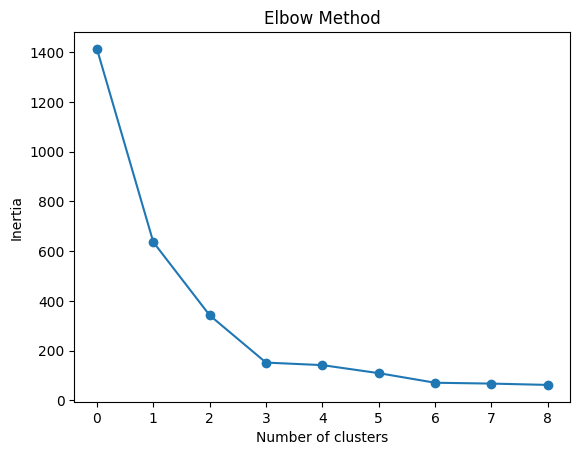

In [31]:
pca = PCA(n_components=None)
dfx_pca = pca.fit(penguins_preprocessed)
dfx_pca.explained_variance_ratio_
n_components = sum(dfx_pca.explained_variance_ratio_ > 0.1)
pca = PCA(n_components=n_components)
penguins_PCA = pca.fit_transform(penguins_preprocessed)
print(n_components)
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(penguins_PCA)
    inertia.append(kmeans.inertia_)
plt.plot( inertia, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

Данные преобразованы методом главных компонентов , метод локтя показал 4 кластера.

In [32]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(penguins_PCA)
y_kmeans = kmeans.predict(penguins_PCA)
umap_2d = UMAP(random_state=0)
umap_2d.fit(penguins_PCA)

projections = umap_2d.transform(penguins_PCA)



fig = px.scatter(
    projections, x=0, y=1,
    color= y_kmeans,
    color_discrete_sequence=["red", "orange", "green","blue","black"],
 labels={'color': 'spiecies'}
)


fig.show()

umap_3d = UMAP(n_components=3, init='random', random_state=0)

proj_3d = umap_3d.fit_transform(penguins_PCA)


fig_3d = px.scatter_3d(
    proj_3d, x=0, y=1, z=2,
    color= y_kmeans, labels={'color': 'spiecies'},
    color_discrete_sequence=["red", "orange", "green", "blue", "black"]
)
fig_3d.update_traces(marker_size=5)

fig_3d.show()

данные отображены в другом пространстве для сравнения .

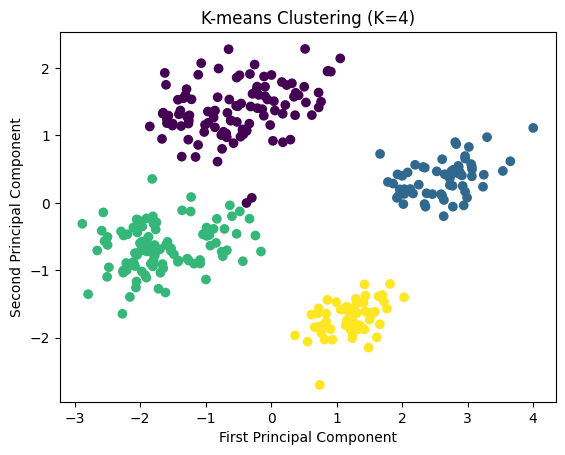

Number of clusters: 4,
 Silhouette Score: 0.65,
 Davies-Bouldin Index: 0.46,
 Inertia: 151.92,
 Calinski-Harabasz Index: 909.96
Average Silhouette Score: 0.65


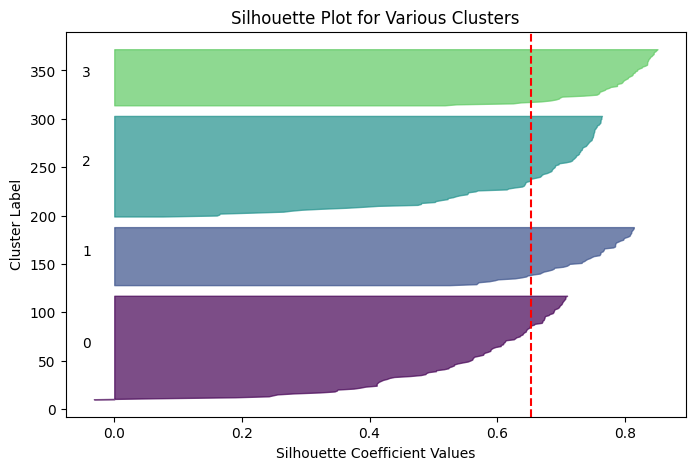

In [33]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(penguins_PCA)
y_kmeans = kmeans.predict(penguins_PCA)
plt.scatter(penguins_PCA[:, 0], penguins_PCA[:, 1], c=y_kmeans, cmap="viridis")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title(f"K-means Clustering (K={n_clusters})")
plt.show()

X=penguins_PCA
labels=y_kmeans
silhouette_scores = []
davies_bouldin_scores = []
inertia_scores = []
calinski_harabasz_scores = []

silhouette_avg = silhouette_score(X, labels)
davies_bouldin = davies_bouldin_score(X, labels)
inertia = kmeans.inertia_
calinski_harabasz = calinski_harabasz_score(X, labels)
print(f"Number of clusters: {n_clusters},\n Silhouette Score: {silhouette_avg:.2f},\n Davies-Bouldin Index: {davies_bouldin:.2f},\n Inertia: {inertia:.2f},\n Calinski-Harabasz Index: {calinski_harabasz:.2f}")

print(f"Average Silhouette Score: {silhouette_avg:.2f}")
scorecomparison = []
silhouette_values = []
scorecomparison.append({'model':'KMeans',
                'Silhouette Score':silhouette_avg})

sample_silhouette_values = silhouette_samples(X, labels)
silhouette_values.append({'model':'KMeans',
                'Silhouette Score':sample_silhouette_values,
                       'labels': labels })
plt.figure(figsize=(8, 5))
y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.viridis(float(i) / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10

plt.title("Silhouette Plot for Various Clusters")
plt.xlabel("Silhouette Coefficient Values")
plt.ylabel("Cluster Label")
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.show()







количество кластеров 4 , при этом значении силуэт  выше чем при 3.

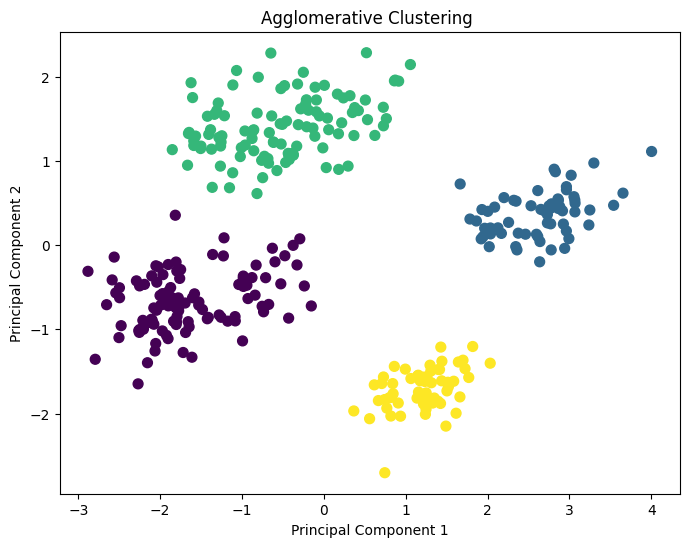

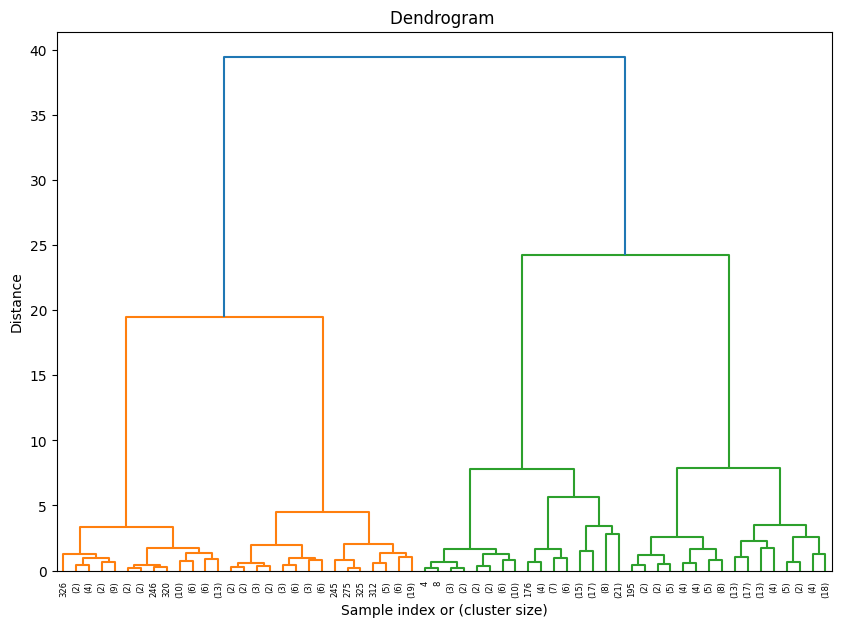

Силуэтовская оценка: 0.65
Индекс Дэвиса-Болдуина: 0.46
Индекс Калински-Харабаса: 904.94


In [34]:
n_clusters = 4
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
predicted_labels = agg_clustering.fit_predict(penguins_PCA)




plt.figure(figsize=(8, 6))
plt.scatter(penguins_PCA[:, 0], penguins_PCA[:, 1], c=predicted_labels, s=50, cmap='viridis')
plt.title("Agglomerative Clustering ")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


plt.figure(figsize=(10, 7))
Z = linkage(penguins_PCA, method='ward')
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Dendrogram ')
plt.xlabel('Sample index or (cluster size)')
plt.ylabel('Distance')
plt.show()


silhouette_avg = silhouette_score(penguins_PCA, predicted_labels)
davies_bouldin = davies_bouldin_score(penguins_PCA, predicted_labels)
calinski_harabasz = calinski_harabasz_score(penguins_PCA, predicted_labels)
scorecomparison.append({'model':'Agglomerative Clustering',
                'Silhouette Score':silhouette_avg})

sample_silhouette_values = silhouette_samples(penguins_PCA, predicted_labels)
silhouette_values.append({'model':'Agglomerative Clustering',
                'Silhouette Score':sample_silhouette_values,
                           'labels': predicted_labels})
print(f"Силуэтовская оценка: {silhouette_avg:.2f}")
print(f"Индекс Дэвиса-Болдуина: {davies_bouldin:.2f}")
print(f"Индекс Калински-Харабаса: {calinski_harabasz:.2f}")





Силуэтовская оценка такая же , как и в k means, однако нет точки , попадающей в чужой класс

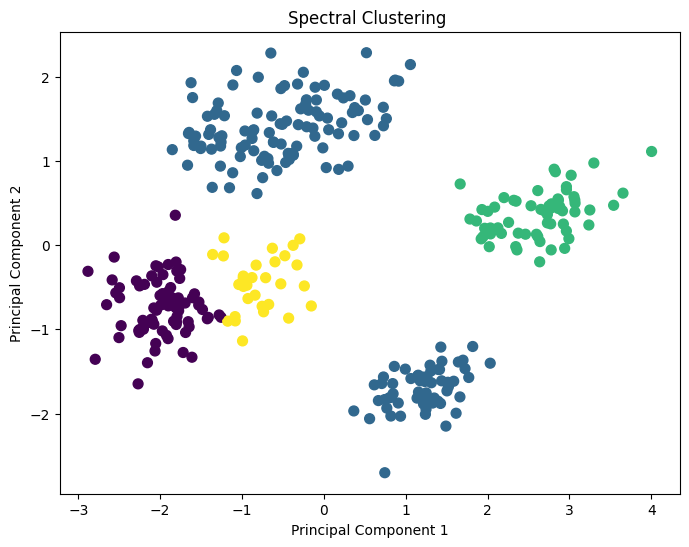

Силуэтовская оценка: 0.30
Индекс Дэвиса-Болдуина: 1.39
Индекс Калински-Харабаса: 149.49


In [35]:
n_clusters = 4
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
predicted_labels = spectral.fit_predict(penguins_PCA)



plt.figure(figsize=(8, 6))
plt.scatter(penguins_PCA[:, 0],penguins_PCA[:, 1], c=predicted_labels, s=50, cmap='viridis')
plt.title("Spectral Clustering ")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

largest_cluster_label = np.argmax(np.bincount(predicted_labels))


silhouette_avg = silhouette_score(penguins_PCA, predicted_labels)
davies_bouldin = davies_bouldin_score(penguins_PCA, predicted_labels)
calinski_harabasz = calinski_harabasz_score(penguins_PCA, predicted_labels)
scorecomparison.append({'model':'SpectralClustering',
                'Silhouette Score':silhouette_avg})
sample_silhouette_values = silhouette_samples(penguins_PCA, predicted_labels)
silhouette_values.append({'model':'Spectral Clustering',
                'Silhouette Score':sample_silhouette_values,
                         'labels': predicted_labels})
print(f"Силуэтовская оценка: {silhouette_avg:.2f}")
print(f"Индекс Дэвиса-Болдуина: {davies_bouldin:.2f}")
print(f"Индекс Калински-Харабаса: {calinski_harabasz:.2f}")




Количество кластеров 4 , однако разделение произошло неправильным образом.

[-1  0  1  2  3  4  5  6  7  8  9 10]


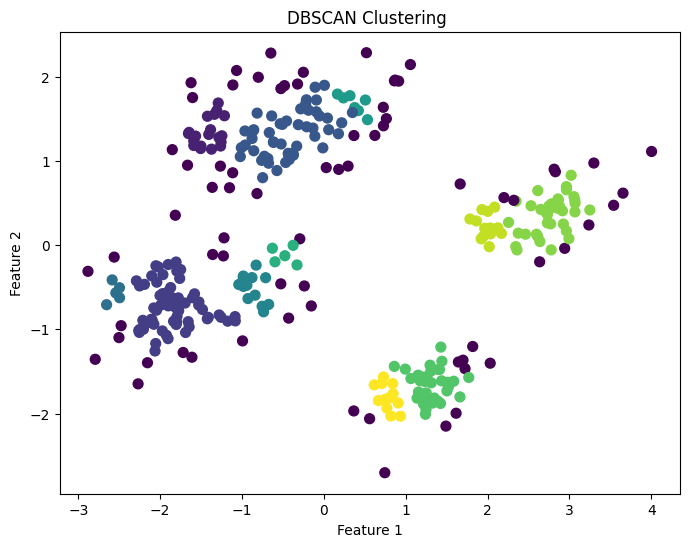

Силуэтовская оценка: 0.40
Силуэтовская оценка: 0.40
Индекс Дэвиса-Болдуина: 0.61
Индекс Калински-Харабаса: 952.55


In [36]:
dbscan = DBSCAN(eps=0.2, min_samples=5) #
predicted_labels = dbscan.fit_predict(penguins_PCA)

print (np.unique(predicted_labels))
plt.figure(figsize=(8, 6))
plt.scatter(penguins_PCA[:, 0], penguins_PCA[:, 1], c=predicted_labels, cmap='viridis', s=50)
plt.title("DBSCAN Clustering ")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

mask = predicted_labels != -1
silhouette_avg = silhouette_score(penguins_PCA[mask], predicted_labels[mask])
davies_bouldin = davies_bouldin_score(penguins_PCA[mask], predicted_labels[mask])
calinski_harabasz = calinski_harabasz_score(penguins_PCA[mask], predicted_labels[mask])
scorecomparison.append({'model':'DBSCAN',
                'Silhouette Score':silhouette_avg})
sample_silhouette_values = silhouette_samples(penguins_PCA[mask], predicted_labels[mask])
dbscanpred = predicted_labels[mask]
silhouette_values.append({'model':'DBSCAN',
                'Silhouette Score':sample_silhouette_values,
                         'labels': dbscanpred})

print(f"Силуэтовская оценка: {silhouette_avg:.2f}")
print(f"Силуэтовская оценка: {silhouette_avg:.2f}")
print(f"Индекс Дэвиса-Болдуина: {davies_bouldin:.2f}")
print(f"Индекс Калински-Харабаса: {calinski_harabasz:.2f}")







Dbscan выделяет 10 классов и шумы (-1 ) силуэтовская оценка низкая , т к выделяются кластеры по плотности.

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93]


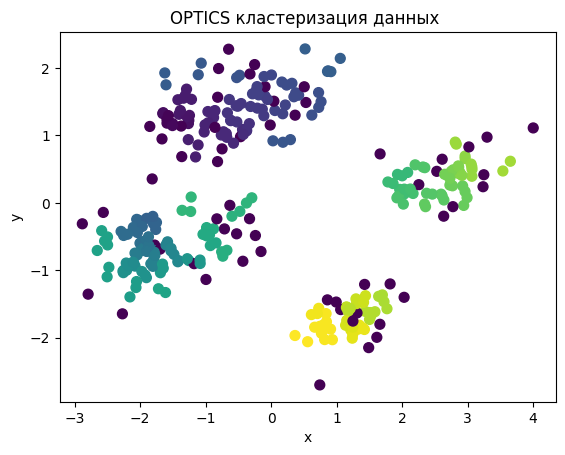

Силуэтовская оценка: 0.26
Индекс Дэвиса-Болдуина: 1.10
Индекс Калински-Харабаса: 10.80


In [37]:

optics = OPTICS(min_samples=2)
predicted_labels = optics.fit_predict(penguins_PCA)
print (np.unique(predicted_labels))
plt.scatter(penguins_PCA[:, 0], penguins_PCA[:, 1], c=predicted_labels, cmap='viridis', s=50)
plt.title('OPTICS кластеризация данных ')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


silhouette_avg = silhouette_score(penguins_PCA, predicted_labels)
davies_bouldin = davies_bouldin_score(penguins_PCA, predicted_labels)
calinski_harabasz = calinski_harabasz_score(penguins_PCA, predicted_labels)
scorecomparison.append({'model':'OPTICS',
                'Silhouette Score':silhouette_avg})
sample_silhouette_values = silhouette_samples(penguins_PCA, predicted_labels)
silhouette_values.append({'model':'OPTICS',
                'Silhouette Score':sample_silhouette_values,
                         'labels': predicted_labels})
print(f"Силуэтовская оценка: {silhouette_avg:.2f}")
print(f"Индекс Дэвиса-Болдуина: {davies_bouldin:.2f}")
print(f"Индекс Калински-Харабаса: {calinski_harabasz:.2f}")

Optics  выделяет очень много классов и не подходит под данные .

                      model  Silhouette Score
0                    KMeans          0.652374
1  Agglomerative Clustering          0.652232
2        SpectralClustering          0.299241
3                    DBSCAN          0.401808
4                    OPTICS          0.255907


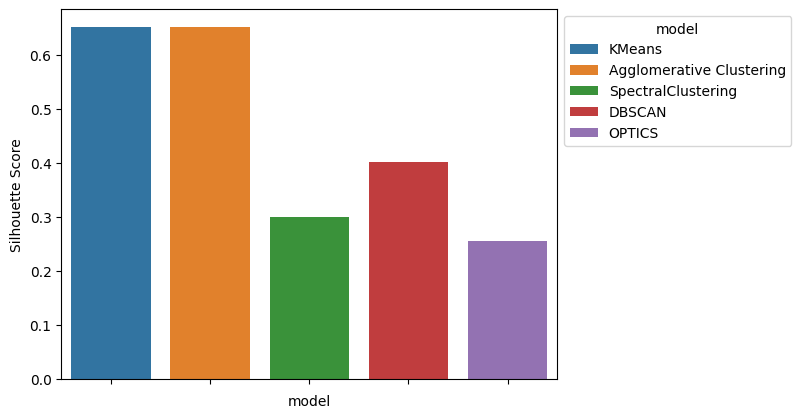

In [38]:
comp = pd.DataFrame.from_records(scorecomparison)
print(comp.head())

score = pd.DataFrame.from_records(silhouette_values)


ax = sns.barplot(comp,x="model",y="Silhouette Score",hue="model",legend='full')
ax.set_xticklabels("")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

Лучше всего работают модели  KMeans и Agglomerative Clustering.

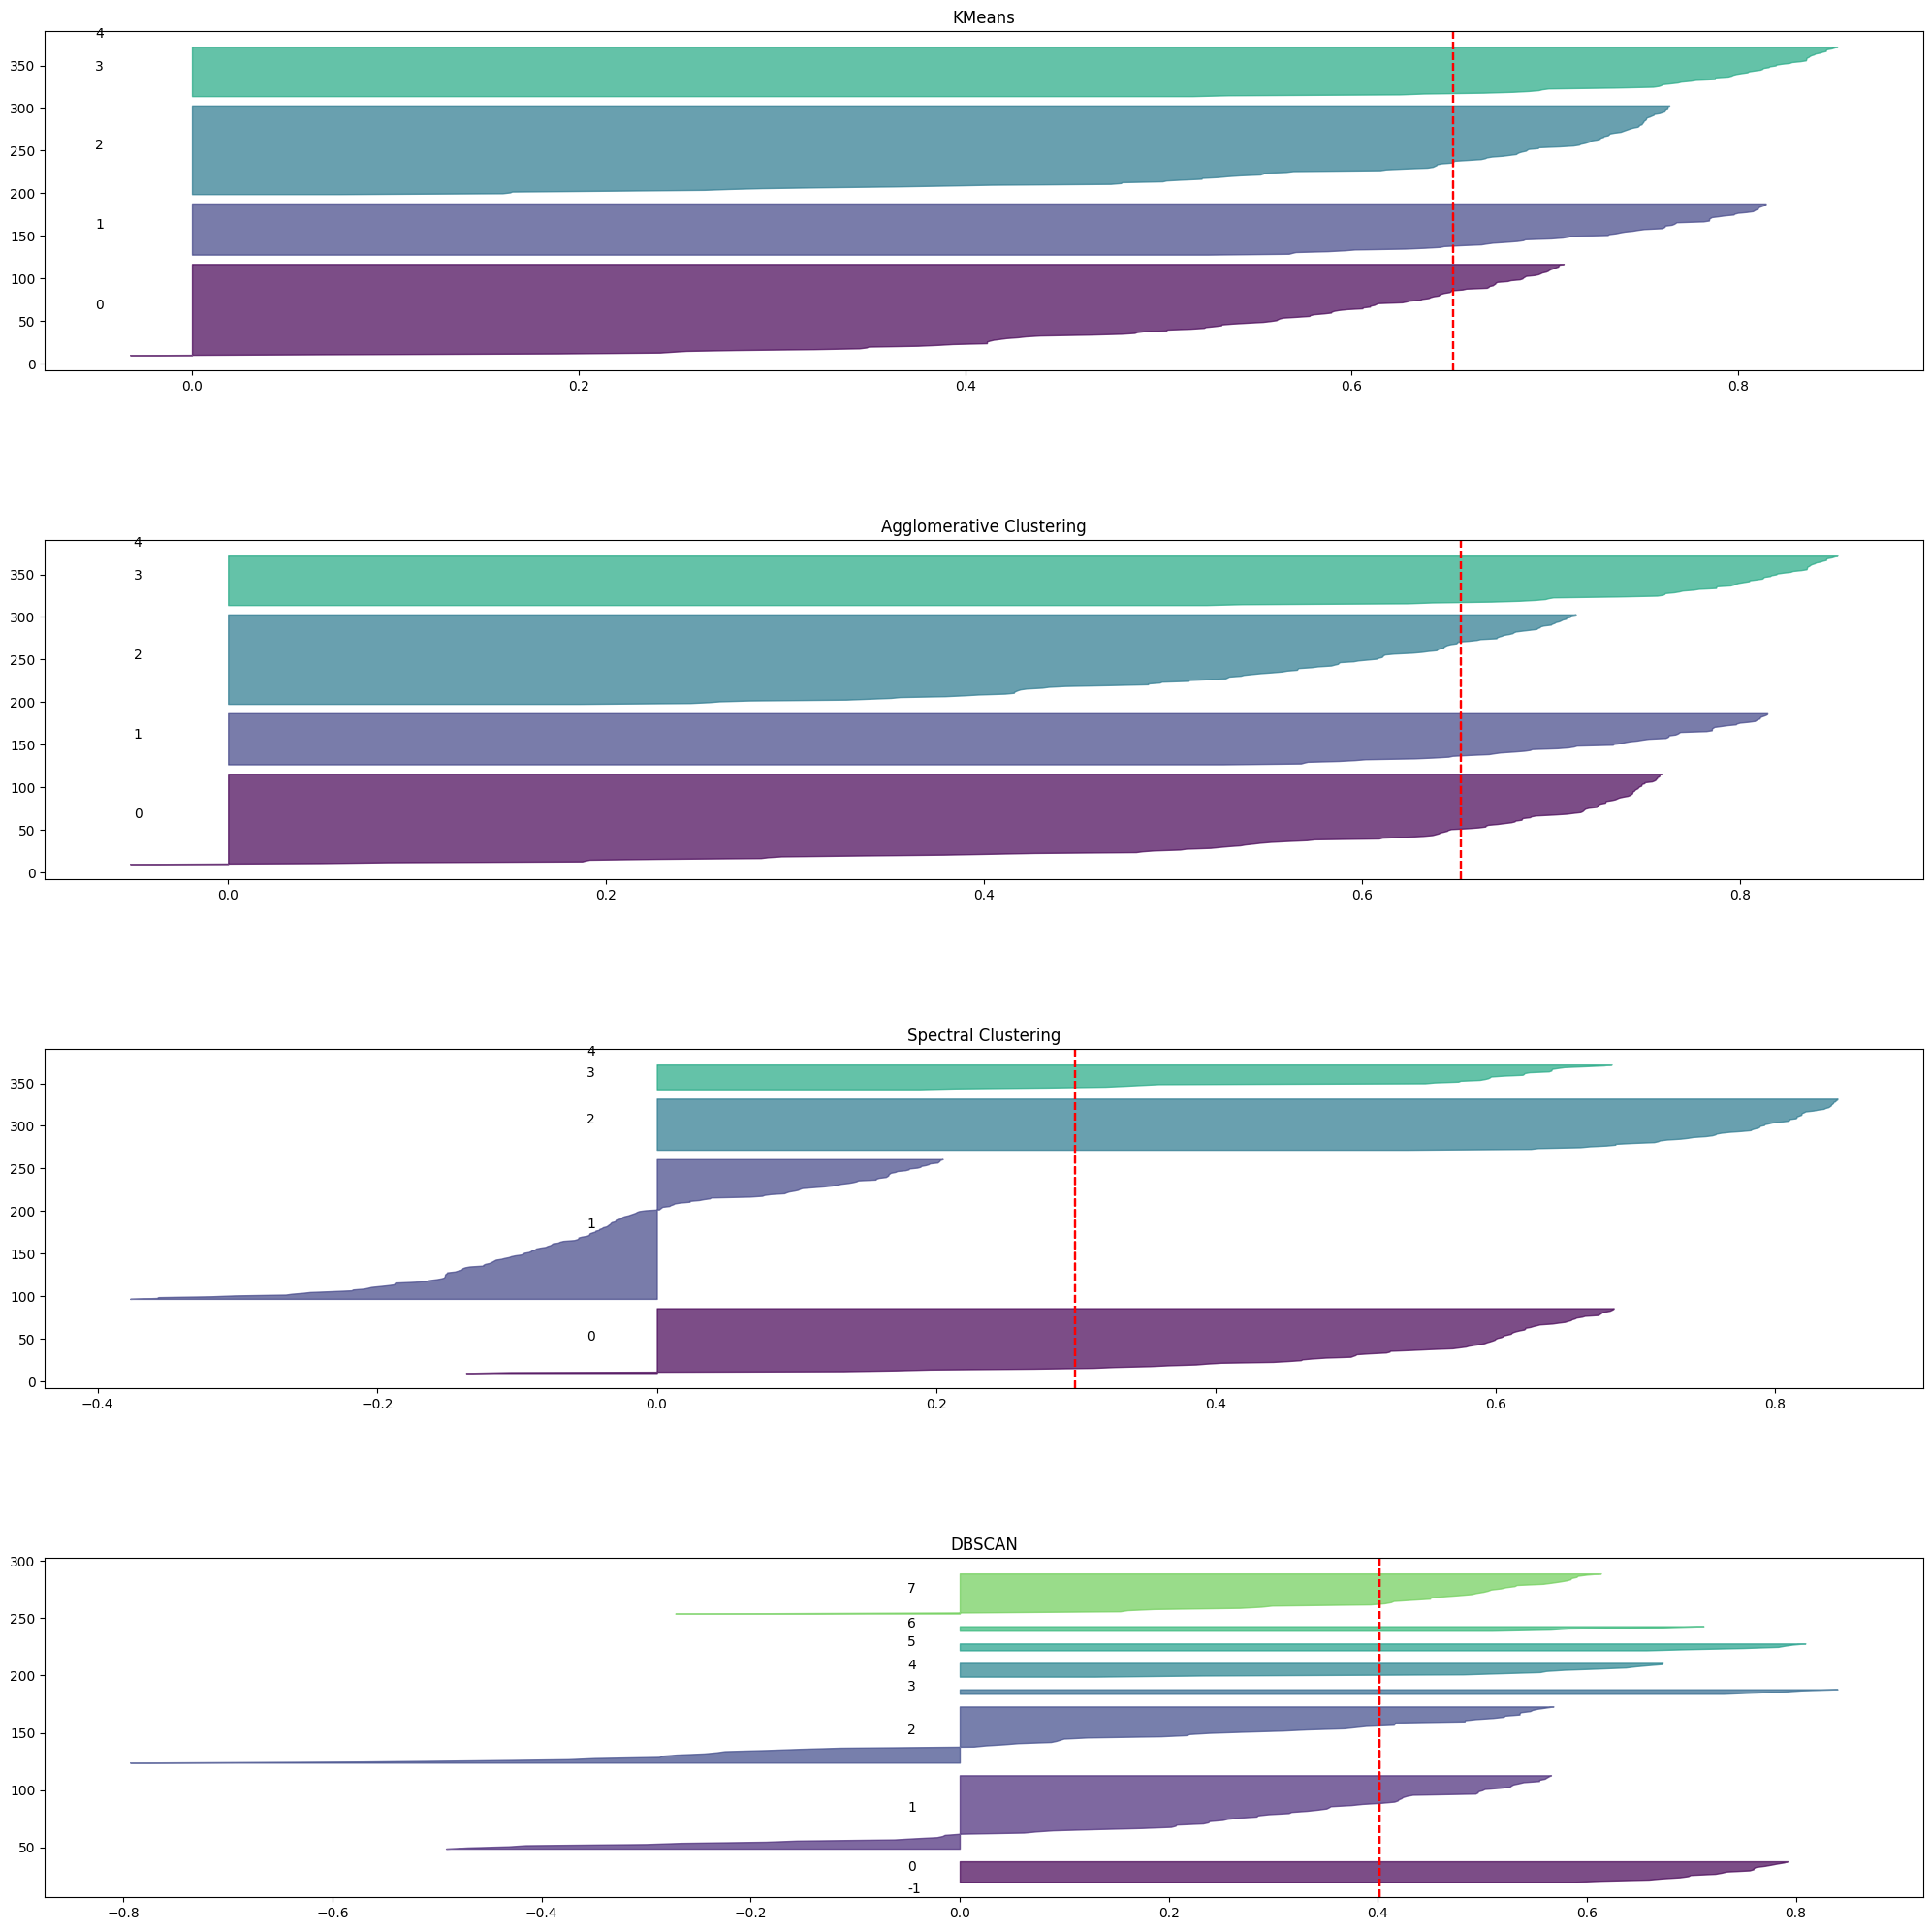

In [39]:




fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(25, 25))
n=0
n_clusters=5

fig.subplots_adjust(hspace=0.5)
for j in range(3):
    y_lower = 10
    for i in range(n_clusters):
       ith_cluster_silhouette_values = score['Silhouette Score'][j][score['labels'][j]== i]
       ith_cluster_silhouette_values.sort()

       size_cluster_i = ith_cluster_silhouette_values.shape[0]
       y_upper = y_lower + size_cluster_i

       color = plt.cm.viridis(float(i) / n_clusters)
       axs[j].set_title(score['model'][j])
       axs[j].fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

       axs[j].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

       y_lower = y_upper + 10

       axs[j].axvline(x=comp['Silhouette Score'][j], color="red", linestyle="--")


y_lower = 10
for i in range(-1,8):
       ith_cluster_silhouette_values = score['Silhouette Score'][3][dbscanpred == i]
       ith_cluster_silhouette_values.sort()

       size_cluster_i = ith_cluster_silhouette_values.shape[0]
       y_upper = y_lower + size_cluster_i

       color = plt.cm.viridis(float(i) / 9)
       axs[3].set_title(score['model'][3])
       axs[3].fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

       axs[3].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

       y_lower = y_upper + 10

       axs[3].axvline(x=comp['Silhouette Score'][3], color="red", linestyle="--")

Графики силуэтной оценки подтверждают  что лучше справляются модели KMeans и Agglomerative Clustering.

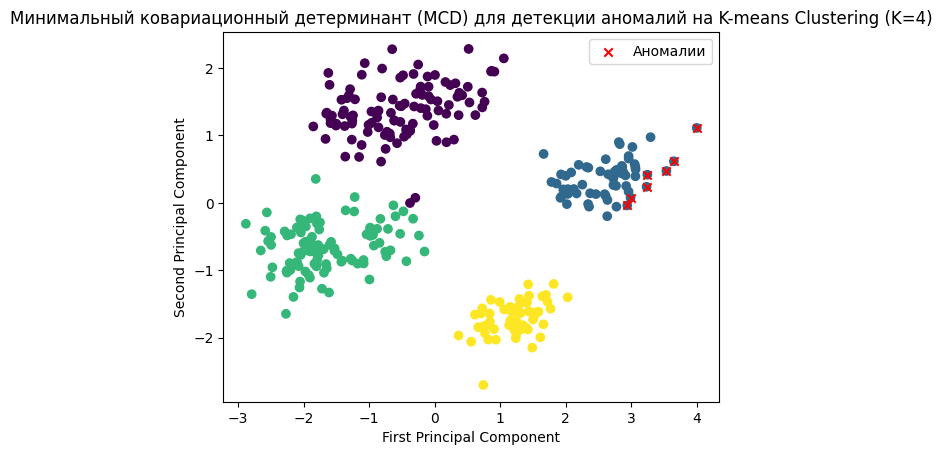

In [40]:
from sklearn.covariance import MinCovDet
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(penguins_PCA)
y_kmeans = kmeans.predict(penguins_PCA)



mcd = MinCovDet()
mcd.fit(penguins_PCA)


mahal_dist = mcd.mahalanobis(penguins_PCA - mcd.location_)
threshold = np.percentile(mahal_dist, 98)



plt.scatter(penguins_PCA[:, 0], penguins_PCA[:, 1], c=y_kmeans, cmap="viridis")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title(f"Минимальный ковариационный детерминант (MCD) для детекции аномалий на K-means Clustering (K={n_clusters})")
plt.scatter(penguins_PCA[mahal_dist > threshold][:, 0], penguins_PCA[mahal_dist > threshold][:, 1], c='red', marker='x', label='Аномалии')
plt.legend()
plt.show()


MCD выделяет 2 процента(заданных) аномалий в зависимости от их отдаления от центров кластеров.

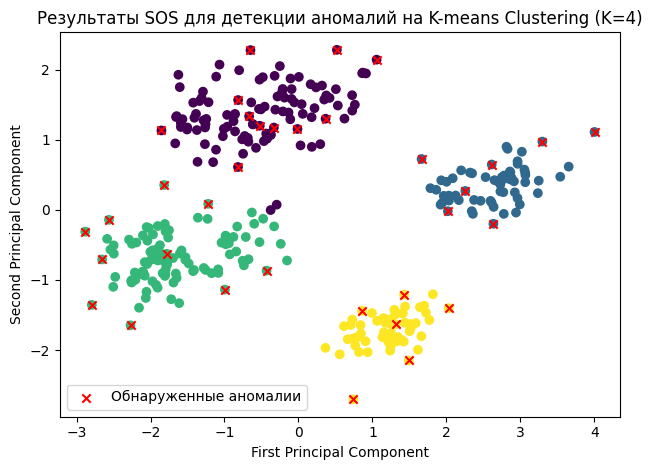

In [41]:
!pip install pyod
from pyod.models.sos import SOS

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(penguins_PCA)
y_kmeans = kmeans.predict(penguins_PCA)
sos = SOS()
sos.fit(penguins_PCA)


y_pred = sos.predict(penguins_PCA)



plt.scatter(penguins_PCA[:, 0], penguins_PCA[:, 1], c=y_kmeans, cmap="viridis")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title(f"Результаты SOS для детекции аномалий на K-means Clustering (K={n_clusters})")
plt.scatter(penguins_PCA[y_pred == 1][:, 0], penguins_PCA[y_pred == 1][:, 1], c='red', marker='x', label='Обнаруженные аномалии')
plt.legend()

plt.tight_layout()
plt.show()

SOS выделяет больше аномалий чем MDC, тк выделяет аномалии по соседним точкам.